WIP notebook for spider plotting




In [1]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import os, sys, math
from pprint import pprint
sys.path.extend(('../reframe', '..')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

In [2]:
class MultiMagSpiderPlot(object):
    # based on https://www.pythoncharts.com/2019/04/16/radar-charts/
    
    def __init__(self, variables, values, alpha=None):
        """ A spider plot where values on different 'legs' may be of different magnitudes.
        
            Args:
                variables: sequence of strings, variable names (=test names, shown on theta positions)
                values: df where columns are variables (=tests), rows are series (=systems/parititions)
                alpha: float giving fill alpha or None for no fill
            
            Each column is scaled so that all data has the same order of magnitude.
        """
        
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))   
        num_vars = len(variables)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        
        # duplicate first column to close data:
        values['_closeup'] = values[values.columns[0]]
        angles += angles[:1]
        
        # fix angle axis and direction:
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        
        # scale by column so that all data has the same order of magnitude:
        base = 10
        maxes = values.agg(max)
        mags = [abs(math.floor(math.log(v, base))) for v in maxes]
        min_mag = min(mags)
        factors = [base ** (min_mag - m) for m in mags]
        values *= factors
        
        # set theta labels and fix positioning:
        theta_labels = []
        for var, factor in zip(variables, factors):
            label = '{} (/ {:,})'.format(var, 1/factor) if factor < 1 else var
            theta_labels.append(label)  
        ax.set_thetagrids(np.degrees(angles), theta_labels)
        for label, angle in zip(ax.get_xticklabels(), angles):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('left')
            else:
                label.set_horizontalalignment('right')
        
        # orientate r labels:
        ax.set_rlabel_position(0)
        
        # make r gridlines non-circular and turn off outer ring:
        gridlines = ax.yaxis.get_gridlines()
        for gl in gridlines:
            gl.get_path()._interpolation_steps = num_vars
        ax.set_frame_on(False)
        
        # transpose so columsn are now system-partitions (become plot series), sorted lexigraphically for easier reading:
        tr_values = values.transpose()
        tr_values = tr_values.reindex(sorted(tr_values.columns), axis=1)
        
        # plot:
        lines = ax.plot(angles, tr_values, linewidth=2)
        ax.legend(lines, tr_values.columns, bbox_to_anchor=(1.5, 1.5))
        if alpha is not None:
            ax.fill(angles, tr_values, alpha=alpha)


/alaska/steveb/miniconda3/envs/hpc-tests/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


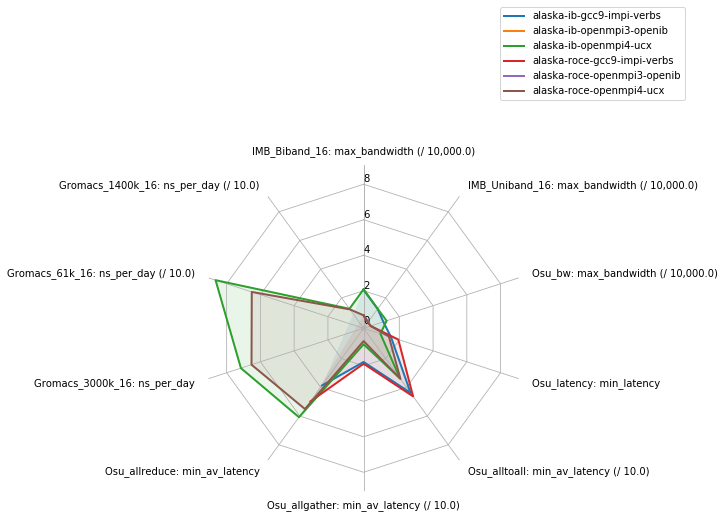

In [3]:
# will only plot a subset of tests:

# TODO: need to retrieve units and add to column titles

tests = [('IMB_Biband_16', 'max_bandwidth'), ('IMB_Uniband_16','max_bandwidth'), # TODO: need to autogenerate largest or best-performing one?
         ('Osu_bw', 'max_bandwidth'),
         ('Osu_latency', 'min_latency'), ('Osu_alltoall', 'min_av_latency'), ('Osu_allgather', 'min_av_latency'), ('Osu_allreduce', 'min_av_latency'),
         ('Gromacs_3000k_16', 'ns_per_day'), ('Gromacs_61k_16', 'ns_per_day'), ('Gromacs_1400k_16', 'ns_per_day'), # TODO: need to autogenerate largest or best-performing one?
        ]

alldf = []
        

# for test in tests: values
for test, perf_var in tests:
    # load perf logs:
    df = modules.utils.load_perf_logs('../perflogs', test, '.log')
    # filter to rows for correct perf_var:
    df = df.loc[df['perf_var'] == perf_var]
    # keep only the LAST record in each system/partition/environment(=test module)
    df = df.sort_index().groupby(['sysname', 'partition', 'environ']).tail(1)    
    # Add "case" column from combined system/partition names (NB don't want/need enviroment as it's equiv. to test):
    df['case'] = df[['sysname', 'partition']].agg('-'.join, axis=1)
    # turn it round so has 'case' as index and a single colum giving perf_values with test and perf_var in column name
    colname = '%s: %s' % (test, perf_var)
    df[colname] = df['perf_value']
    df = df[['case', colname]]
    df = df.set_index('case')
    alldf.append(df)

# concatenate tests together by case - missing tests get filled with NaN:
results = pd.concat(alldf, axis=1, sort=False)
# print('Results:')
# print(results)
# print()

MultiMagSpiderPlot(results.columns, results, 0.1)
